# Todo
- [x] add code :)
- [x] Calculate Flowspeed in pipe without knowing the friction it causes
- [x] Come up with a way to let the user design, save and edit fludi plans
- [x] Fix bug, only first defined component does anythin
- [ ] Clean up the code
- [ ] check out cool pdf https://www.gunt.de/images/download/Basiswissen-Strmung-in-Rohrleitungen-und-Armaturen_german.pdf

# What does it do?
This skript enables you to calculate the pressure drop curve and expected massflow over a fluid system of pipes and fixtures, such as pumps, given a massflow range.   
For an indepth theoretical explanation of whats going on, go to the bottom. Its out of date atm. Sry :(
# How do I use it?
All you need to do is eddit the code cells below "Important inputs" and "Create fluid system". Hit run all cells and get your pressure drop curve.   
For ease of use collaps code cells below "Defining Classes for Fluid system Objects", "Results:" and the import cell below this one.

In [1]:
# Library imports here, collapse cell for general use:
import numpy as np  # makes math go brrr
import matplotlib.pyplot as plt  # makes nice plots

# Important inputs

In [2]:
lower_massflow = 0  # in kg/s
upper_massflow = 0.5  # in kg/s  # 0.138
density = 1000  # in kg/m³
resolution = 1000  # number of massflows created between lower and upper_massflow, this impacts how precise your results will be
tank_pressure = 40 # in bar
engine_pressure = 35 # in bar

### Defining Classes for Fluid system Objects
Keep collapsed for general use, no input needed

In [3]:
# functions and classes
# functions not used at the moment, so they are commented out
# def end_velocity(start_velocity:float, start_height:float, end_height:float, start_pressure:float, end_pressure:float, pressure_loss:float, density:float, grav_accel:float) -> float:
#     """This function uses bernoullis equation in order to calculate the exit velocity of a fluidstream after it passes through a system of pipes, valves etc.
#     
#     Args:
#         start_velocity (float): [m/s] The velocity the fluid has at the point the analysis is begun
#         start_height (float): [m] The height from the level line to where the analysis is begun
#         end_height (float): [m] The height from the level line to wehere the analysis ends
#         start_pressure (float): [Pa] The pressure of the fluid at the start of the analysis
#         end_pressure (float): [Pa] The pressure of the fluid at the end of the analyis
#         pressure_loss (float): [Pa] The amount of pressure lost from beginning to end of the analyisis due to the fluid system
#         density (float): [kg/m³] The density of the fluid in question
#         grav_accel (float): [m/s²] The acceleration of the analysed system, during analysis
# 
#     Returns:
#         end_velocity (float): [m/s] The velocity the fluid has at the point the analysis ends
#     """
#     # bernoulli rearanged for end velocity is calculated
#     end_velocity = np.sqrt(start_velocity^2 + 2*( grav_accel*(start_height - end_height) + (start_pressure - end_pressure - pressure_loss)/(density) ))
#     # and returned
#     return end_velocity
# 
# 
# def start_pressure(density:float, end_velocity:float, start_velocity:float, grav_accel:float, end_height:float, start_height:float, end_pressure:float, pressure_loss:float) -> float:
#     """This function uses bernoullis equation to calculate the required start pressure in order to achive a certain end velocity.
#     
#     Args:
#         end_velocity (float): [m/s] The velocity the fluid has at the point the analysis ends
#         start_velocity (float): [m/s] The velocity the fluid has at the point the analysis is begun
#         grav_accel (float): [m/s²] The acceleration of the analysed system, during analysis
#         end_height (float): [m] The height from the level line to wehere the analysis ends
#         start_height (float): [m] The height from the level line to where the analysis is begun
#         end_pressure (float): [Pa] The pressure of the fluid at the end of the analyis
#         pressure_loss (float): [Pa] The amount of pressure lost from beginning to end of the analyisis due to the fluid system
# 
#     Returns:
#         end_pressure (float): [Pa] The pressure of the fluid at the end of the analyis
#     """
#     # bernoulli reagranged for startin pressure is calculated
#     start_pressure = density * ( (end_velocity^2 - start_velocity^2)/2 + grav_accel*(end_height - start_height) + end_pressure + pressure_loss)
#     # and returned
#     return start_pressure
# 
# # should ad a method to change the order of the objects in the component.list, maby
# class component:
#     # Components are a generelasation of pipes and fixtures.
#     # all components are saved in this list, by order of creation
#     list = []
#     # instance constructor
#     def __init__(self, name:str, order_number:int) -> None:
#         self.order_number = order_number  # The order of the component in the fluid system.
#         self.name = name
#         self.list.append(self)  # add this object to the list of compoents
#         self.flow_speeds = []  # stores all the flowspeeds generated by different volume flows
#         self.norm_pressuredrops = []  # a list of pressure drops normalized over the density generated by the flow speeds above
#     # charakteristic string, you will see this when you print(instance) for an instance of the component class
#     def __str__(self) -> None:
#         return f"Type:{type(self).__name__}; Name:{self.name}; Number:{self.order_number}; Flow_Speed:{self.flow_velocity} m/s"
#     # this method removes the object from the list
#     def remove(self):
#         type(self).list.remove(self)

class pipe(component):
    # A pipe is a component wich also has a lenth, diameter, and a tube friction coeffficient.
    # All other instance attributes are inherited from the component class
    def __init__(self, name, order_number, lenth:float, diameter:float, tube_friction_coefficent:float) -> None:
        super().__init__(name, order_number)
        self.lenth = lenth
        self.diameter = diameter
        self.area = (diameter/2)**2 * np.pi  # Calculate crossectional area of pipe
        self.tube_friction_coefficent = tube_friction_coefficent
    # inheret the charakterisic string of the component class, and append new attributes
    def __str__(self) -> str:
        return super().__str__() + f"Lenth: {self.lenth} m; Diameter: {self.diameter} m; Tube_friction_coefficent: {self.tube_friction_coefficent}"
    
    def pressure_drop(self):
        # for each flow speed throug the pipe, calculate the pressure drop, normalized by the density, generated by the pipe, save all drops to self.pressure_drops
        for flow_speed in self.flow_speeds:
            self.norm_pressuredrops.append(self.tube_friction_coefficent * self.lenth * flow_speed**2 / (self.diameter*2))  # Pressure / density in m²/s²
        

class fixture(component):
    # A fixture is a component that also has a pressure loss number
    # All other instance attributes are inherited from the component class
    def __init__(self, name, order_number, pressure_loss_number:float, area) -> None:
        super().__init__(name, order_number)
        self.pressure_loss_number = pressure_loss_number
        self.area = area  # the smallest crossectional area of the component
    # inheret the charakterisic string of the component class, and append new attributes
    def __str__(self) -> None:
        return super().__str__() + f"Pressure_loss_number: {self.pressure_loss_number}"

    def pressure_drop(self):
        # for each flow speed throug the fixture, calculate the pressure drop, normalized by the density, generated by the fixture, save all drops to self.pressure_drops
        for flow_speed in self.flow_speeds:
            self.norm_pressuredrops.append(self.pressure_loss_number * flow_speed**2 / 2)  # Pressure / density in m²/s²

# Create fluid system
You can create pipes and fixtures. Both have different properties. All arguments are needed. Examples below. Units:
- lenth and diameter in m
- area in m²
- tube_friction_coefficent and  pressure_loss_number are dimensionless

In [4]:
# create some objects ----------------------
pipe1 = pipe(name="Rohr1", order_number= 0,lenth=10, diameter=0.05, tube_friction_coefficent=3)
pipe2 = pipe(name="Rohr2", order_number=1, lenth=20, diameter=0.05, tube_friction_coefficent=3)
fixture1 = fixture(name="fixture1", order_number=2, pressure_loss_number=7, area=0.0001)

# Results:
Keep collapsed for general use, no input needed

massflow: 0.2927927927927928 kg/s


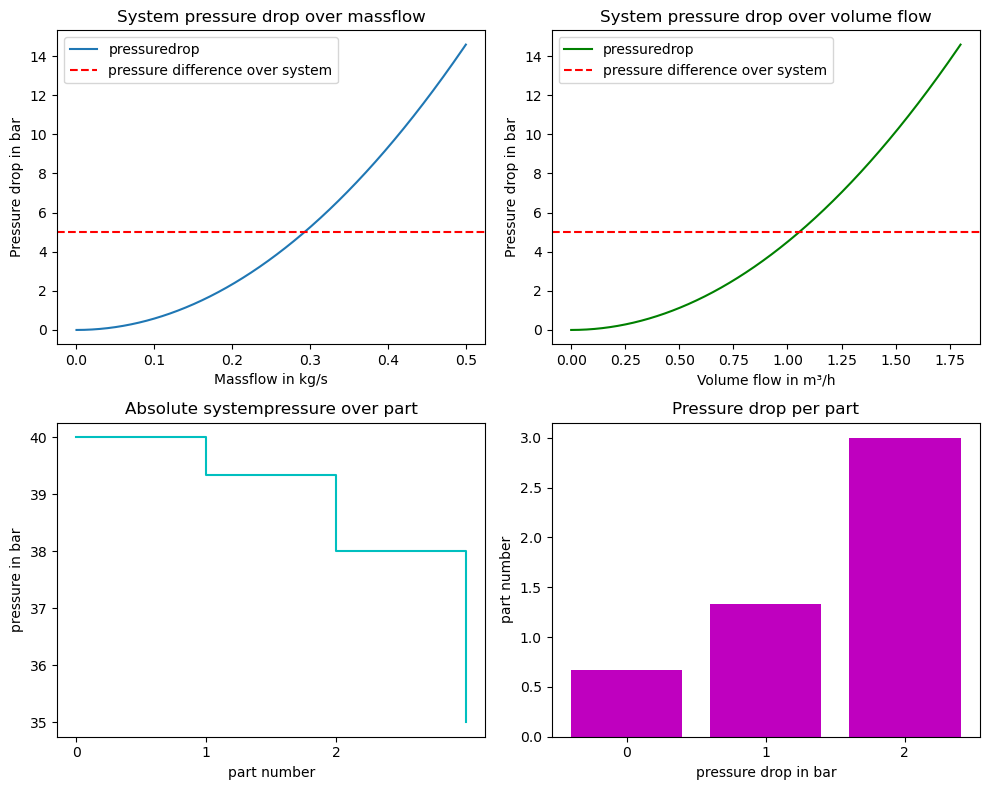

In [5]:
#  main fluid dynamics logic
# ------------------------------------------------------------------

massflows = np.linspace(lower_massflow, upper_massflow, resolution)  # create an array of evenly spaced massflows to examine in between the expected range
volume_flows = massflows / density  # Devide the massflows by the fluids density to recive an array of volume flows

for part in component.list:
    part.flow_speeds = volume_flows / part.area # here we use flow_speed = volume_flow / area to save the flow speed achived in each part
    # here the pressure drop method of the part calculates the pressure drop caused by each flow speed (normalized by the density), note that this method is different between
    # pipes and fixtures
    part.pressure_drop()

# add the normalized pressure loss generated by all parts at each mass flow together and add them to this list
norm_system_pressure_drops = []
# itterate through all the mass flows, and get the index i for each one
for i in range(len(massflows)):
    # for each massflow add an entry to the list
    norm_system_pressure_drops.append(0)
    # itterate through all the parts and get the normalized pressure drop caused by the associated massfow, add that to the overall normalized pressure drop for that massflow
    # this way we get the sum of all normalized pressure drops caused by all parts in the system, for each massflow
    for part in component.list:
        norm_system_pressure_drops[i] += part.norm_pressuredrops[i]


# first multiply norm_system_pressure_drops by the density to denormalize the pressure drop and recive an output in Pa
# then devide that by 10⁵ to get an output in bar
bar_system_pressure_drops = [(drop * density / 10000) for drop in norm_system_pressure_drops]

# find the actual massflow
pressure_difference = tank_pressure - engine_pressure  # the pressure differecne the system can work with in bar
for i, drop in enumerate(bar_system_pressure_drops):
    if drop > pressure_difference:  # when pressure diffrence and loss over the system are the same, a stabel massflow is reached
        # the massflow will always be slightly higher than in reality
        expected_massflow = (massflows[i])
        expected_massflow_index = i
        print(f"massflow: {expected_massflow} kg/s")
        break


# Visualize pressure drop over massflow
# plt.plot(massflows, bar_system_pressure_drops, label='pressuredrop')
# plt.xlabel('Massflow in kg/s')
# plt.ylabel('Pressure drop in bar')
# plt.title('System pressure drop over massflow')
# plt.axhline(y=pressure_difference, color='r', linestyle='--', label=f'pressure diffrence over system')
# plt.legend()
# plt.show()

# Visualize pressure drop over volumeflow
# plt.plot([flows * 60 * 60 for flows in volume_flows], bar_system_pressure_drops, label='pressuredrop', color="g") # convert volume flow to m³/h from m³/s
# plt.xlabel('Volume flow in m³/h')
# plt.ylabel('Pressure drop in bar')
# plt.title('System pressure drop over volume flow')
# plt.axhline(y=pressure_difference , color='r', linestyle='--', label=f'pressure diffrence over system')
# plt.legend()
# plt.show()

# Visualize pressure before and after each component
pressure_at_part = [tank_pressure]
pressure = tank_pressure
for part in component.list:
    pressure = pressure - part.norm_pressuredrops[expected_massflow_index] * density / 10000
    pressure_at_part.append(pressure)
parts = list(range(-1, len(component.list)))
# plt.step(parts, pressure_at_part, where='post', color="c")
# plt.xticks(range(min(parts), max(parts) + 1))
# plt.xticks(ticks=parts[1:], labels=parts[1:])
# plt.xlabel('part number')
# plt.ylabel('pressure in bar')
# plt.title('Absolute pressure over part')
# plt.show()

# Visualize pressure drop of each component
p_drop_per_part = []
for part in component.list:
    p_drop_per_part.append(part.norm_pressuredrops[expected_massflow_index] * density / 10000)
# plt.bar([str(part) for part in parts[1:]], p_drops, color="m")
# plt.xlabel('part number')
# plt.ylabel('pressure drop in pa')
# plt.title('Pressure drop per part')
# plt.show()




# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1: Visualize pressure drop over massflow
axs[0, 0].plot(massflows, bar_system_pressure_drops, label='pressuredrop')
axs[0, 0].set_xlabel('Massflow in kg/s')
axs[0, 0].set_ylabel('Pressure drop in bar')
axs[0, 0].set_title('System pressure drop over massflow')
axs[0, 0].axhline(y=pressure_difference, color='r', linestyle='--', label=f'pressure difference over system')
axs[0, 0].legend()

# Plot 2: Visualize pressure drop over volumeflow
axs[0, 1].plot([flows * 60 * 60 for flows in volume_flows], bar_system_pressure_drops, label='pressuredrop', color="g")
axs[0, 1].set_xlabel('Volume flow in m³/h')
axs[0, 1].set_ylabel('Pressure drop in bar')
axs[0, 1].set_title('System pressure drop over volume flow')
axs[0, 1].axhline(y=pressure_difference, color='r', linestyle='--', label=f'pressure difference over system')
axs[0, 1].legend()

# Plot 3: Visualize pressure before and after each component
axs[1, 0].step(parts, pressure_at_part, where='post', color="c")
axs[1, 0].set_xticks(range(min(parts), max(parts)))
axs[1, 0].set_xticklabels(parts[1:])
axs[1, 0].set_xlabel('part number')
axs[1, 0].set_ylabel('pressure in bar')
axs[1, 0].set_title('Absolute systempressure over part')

# Plot 4: Visualize pressure drop of each component
axs[1, 1].bar([str(part) for part in parts[1:]], p_drop_per_part, color="m")
axs[1, 1].set_xlabel('pressure drop in bar')
axs[1, 1].set_ylabel('part number')
axs[1, 1].set_title('Pressure drop per part')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the combined plot
plt.show()


# How does it work?
The pressure drop over a system must always be equal to the pressure diffrence before and after the system. Therefore if we calculate lots of pressure drops using different massflows, the one that results in a pressuredop equal to the pressure diffrence must have used the correct massflow to calculate it.


# Goal and Method
The goal of this program is twofold. Both of which concern themselves with a pressure-fed rocket engine and how to make the fluid system "work".
## 1. Maximum Achievable Massflow
One goal is to calculate the maximum achievable massflow within the injector. This will help validate if changes to the fluid system will make the massflow fall below our minimum requirements to power the engine. There is no "too high massflow" as it can be regulated down by lowering the tank pressure using a pressure regulator. The massflow is the product of flow speed at the injector nozzle, the area of the nozzle, and the density of the flowing fluid. All these parameters must be known in order to calculate it. While the density of the fluids and the area of the nozzle are somewhat static parameters, the speed of injection is (among other factors) dependent on the pressure drop over the system, as can be seen in Bernoulli's equation for pipe flows with loss.

### Speed

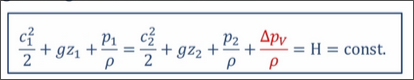

c_1: Velocity at start <br>
z_1: Height at start <br>
p_1: Pressure at start <br>
c_2: Velocity at end <br>
z_2: Height at end <br>
p_2: Pressure at end <br>
rho: Density of fluid <br>
g: Acceleration due to gravity <br>
delta_p: Pressure drop term <br>

In order to get the end velocity out of this equation, we need to rearrange it.

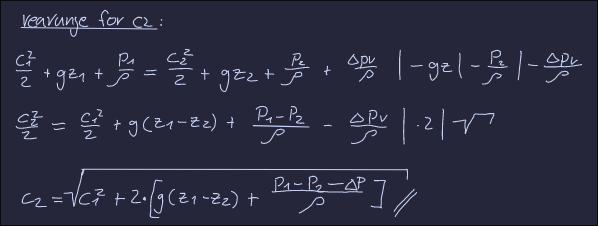

Now it's possible to know c_2​ if you know all of the parameters. These are dependent on how we define our fluid system. This definition is meant to be modular in the program, allowing the user to create their own systems and change them around. And while we will get to that later, most explanations are made easier by an example, so let's define a simple system now! It will consist of a pressurized tank, a pipe, a bend, a valve, and a nozzle. So basically, it's a finished (monopropellant) test stand!!!

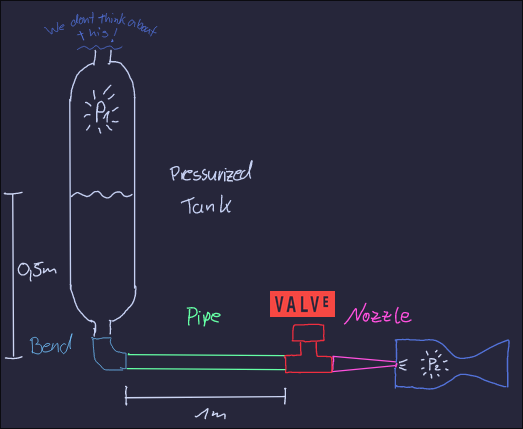

<mark>c_1</mark> is the speed of the fuel within the tank; maybe we can find out what that actually is...or we can just assume it's pretty slow, maybe about c_1 ​= 0 for now! I'm sure that won't cause any problems!<br>
<br>
<mark>g</mark> can be set to g_0 = 9.8 m/s^2 for the test stand, as it is on Earth as far as I know. We might want to play with this value for the finished rocket to find out what happens to the engine under acceleration or in free fall.<br> 
<br>
<mark>z_1</mark>, the height of the fluid level (in the tank), this one is nasty, as it will change over the flight, but lets just assume its a static z_1 = 0.5 m for now. The height of the nozzle will be at the ground so that makes z_2 = 0.<br> 
<br>
<mark>p_1</mark> is the pressure caused by the inert gas layer within the fuel tank, as this is backfilled from another tank, and kept constant by a pressure regulator, let's set it to p_1 = 25 bar = 2500000 pa. p_2 is the pressure within the engine, I thoroughly hope someone else has calculated this because I really can't be bothered. Let's call it p_2 = 5bar = 500000 pa. <br>
<br>
<mark>rho</mark> denotes the density of the propellant, as we're using a monopropellant for this example, let's just say it's hydrazine. Hydrazine has a density of rho = 1.0212 g/cm³ = 1021.2 kg/m³.<br>
<br>
<mark>delta_p</mark>, finally we have the pressure loss term, this represents the pressure lost to wall friction and fixtures within the system, and is deserving of its own chapter.

### Pressure loss
For a full overview of how to calculate pressure loss, check out these [slides](https://droplet.tail3eae4.ts.net/s/rjMjg2Y6cMJdrcL) from the chair of fluid dynamics at the TU Berlin. I took all my knowledge from those anyway! Hope you speak German, LMAO! <br>
<br>
Now let's get on with the example. Trust me; it exists to explain this stuff to me as much as it exists to explain stuff to you. As for calculating the pressure loss, see the slide below.

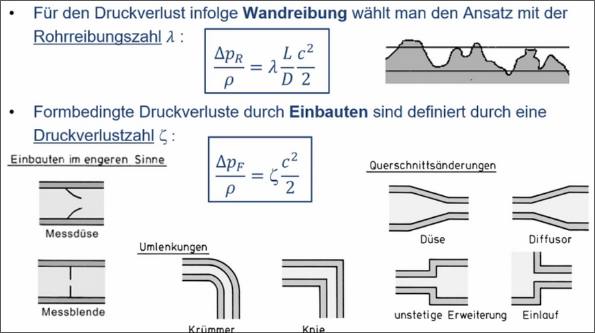

lambda: Tube Friction Coefficient<br>
L: Length of pipe<br>
D: Diameter of pipe<br>
c: Speed of flow<br>
Xi: Pressure loss number <br>
<br>
Aha, here come the problems! See that, the pressure loss in a pipe due to wall friction and due to fixtures is proportional to the square of the flow speed within the pipe. But, we don't know that speed. So we gotta find out the average speed within the pipe, I guess. Well, that's gonna be hard. If I don't come up with anything better, I could run everything once without pipe wall friction and fixtures, get the flow speed, and then run again with...but hell, I'm not sure about any of this at this point!

### Wall Friction
Let's get on with wall friction. How do we calculate Tube Friction Coefficient (\(\lambda\))? The answer: this horrible analog graph!


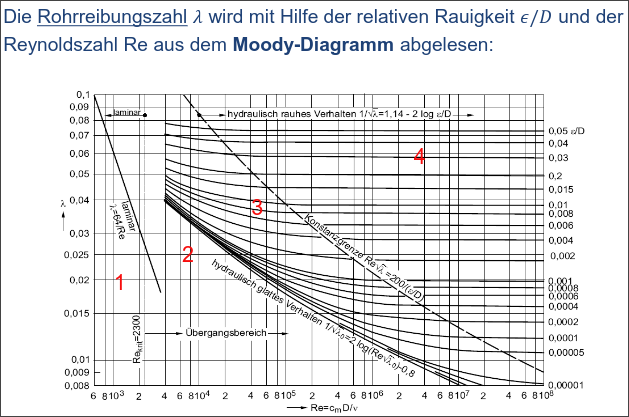

Re: Reynolds Number<br>
epsilon/D: Relative Roughness<br>



Yeah, how the heck am I gonna make this digital!?

### Fixtures
Everything that isn't wall friction is defined by fixtures. So that's Nozzles, bends, diffusers, valves, and whatnot. And those are only defined by their pressure loss number. We will stay focused on our example for now. So let's start off with a bend!

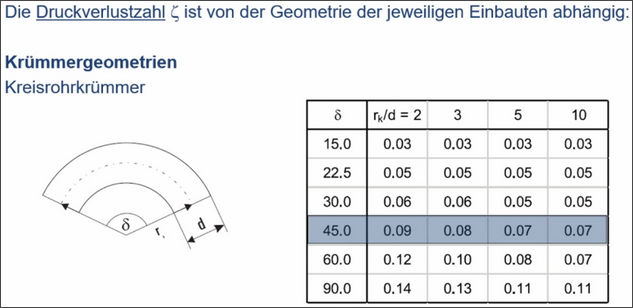

Ok, so it's a 90° bend, and let's give it a bend radius to diameter ratio of 5, that makes \(\Xi = 0.11\). EZ. Next up is the pipe. We'll use relative wall friction as discussed above. Next up, it's the valve. Its pressure loss number should be given by the manufacturer. Now, only the nozzle remains. Its pressure loss number can be taken from the following table.

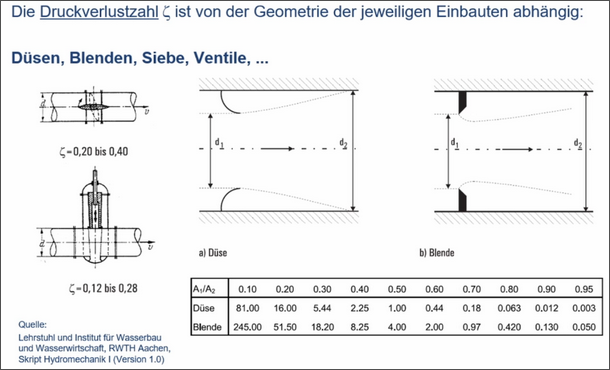


## 2. Required Pressure to Reach a Given Mass Flow
The second goal of the program. Here, we figure out which tank pressure results in the mass flow that we want. This should only take some rearranging of the Bernoulli equation, and then we will be fine.

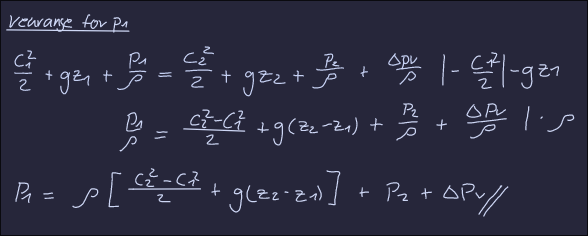

That's actually it. Now all we need to do is come up with a clever way to design and save fluid systems for the program to evaluate. Doing it anew every time won't suffice; this is meant to save time, after all!


# Lets write some code!

Lets start of by defining the end_velocity(), start_pressure() and pressure_loss() functions. These three functions do what was discussed above, and what their names imply. Furthermore we shall start to define the component class and its subclasses pipe and fixture. Objects from these classes will hold all the information needed to calculate their pressure drop using the pressure drop function. I might also implement pressure_loss() as an instance method and not as a fuction. This might be easyer depending on how much the objects vary.

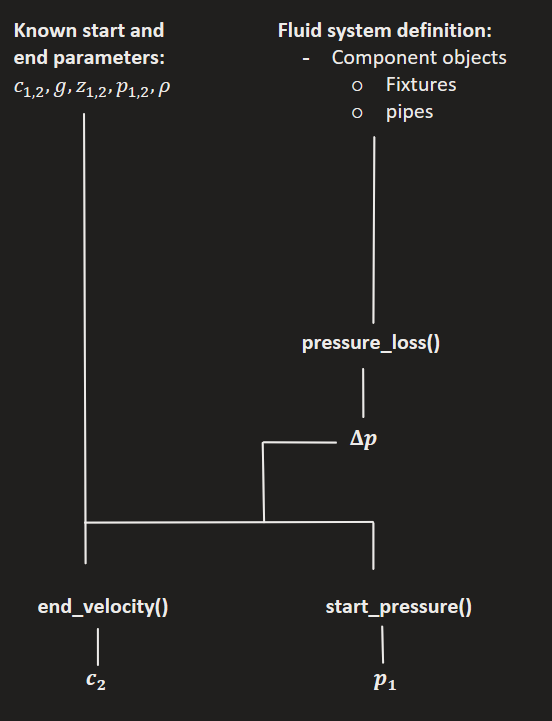

.